# **Can You Judge A Book by Its Cover?**
##Data Exploration
DATASCI 112 FINAL PROJECT

By: Serena Lee and Sunny Yu

# Data Exploration: Analyzing trends in average book ratings and types of books being published. 

### Our data comprised 24,971 books published between 120AD - 2023 and spanned authors from 67 countries. We wanted to explore trends across time, country and genre.

Our exploration led us to these questions:

1. Where are the authors in our dataset from? Which countries produced the most best-selling authors?*
2. Which genres were trending at what times? 
3. What were the most common first words in books with ratings above 4.0+?
4. How does book popularity (average rating and/or number of reviews) correlate with features like: the kinds of words in the book description and book title?

In [63]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
!pip install geopandas

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
#pathways
books_csv = "/content/drive/MyDrive/Data Science Final Project/books_clean.csv"
goodreads_csv = "/content/drive/MyDrive/Data Science Final Project/data from other sources/good_reads_final.csv"
lat_long_csv = "/content/drive/MyDrive/Data Science Final Project/data from other sources/world_country_and_usa_states_latitude_and_longitude_values.csv"

In [66]:
df_books = pd.read_csv(books_csv)

In [67]:
len(df_books)

df_books.columns

Index(['title', 'author', 'book_index', 'book_url', 'avg_rating', 'genre',
       'description', 'publication_year', 'first_sentence',
       'number_of_reviews', 'image_url'],
      dtype='object')

**Exploration Q1: When were our books published?**

*  We definitely saw some weird things when we checked the publication years for our books. We had extreme numbers like 120 and 2918 (huh?... impossible!). However, we realized it was not a fault of our scraping, but rather that the website we scraped, LibraryThing, is a community-volunteer platform and sometimes humans make typos. 

For instance, the book published in "2918" was actually published "2018" (The Tuscan Child, by Janet Quin-Harkin). This typo was repeated in 2029 (which we checked should be 2020). 
** we fixed all these errors in the Data Cleaning notebook, so the output here does not show it!


*   Interestingly, the book published in 120 was indeed correct! We had the "History of the Twelve Caesars" in our dataset -- a biography of Roman Ceasars by ancient historian Suetonius.





In [68]:
df_books['publication_year'].value_counts().sort_index(ascending=True)

120       1
158       1
397       2
426       1
1120      1
       ... 
2019    203
2020    192
2021    126
2022     87
2023      3
Name: publication_year, Length: 312, dtype: int64

In [69]:
#actually from 120AD
df_books.loc[df_books['publication_year'] == 120]

,title,author,book_index,book_url,avg_rating,genre,description,publication_year,first_sentence,number_of_reviews,image_url
7228,History of the Twelve Caesars,Suetonius,7228,https://www.librarything.com//work/21348,4.04,"['Nonfiction', 'History', 'Biography & Memoir']","As private secretary to the Emperor Hadrian, t...",120,"In the course of his sixteenth year, he lost h...",69,https://images-na.ssl-images-amazon.com/images...


# Question 1: Which countries produce the most best-selling authors in our data set?

### Exploring the birthplaces of our authors by making a dot map of authors grouped by their birthplace, scaled according to authors' average ratings.

In [70]:
#merge book data frame with author info 
df_author = pd.read_csv(goodreads_csv)
df_author = df_author.drop_duplicates(subset='author_name', ignore_index=True)
len(df_author)

12156

In [71]:
#clean data for the author data frame 
df_author['author_name'] = df_author['author_name'].str.strip()
df_author['birthplace'] = df_author['birthplace'].str.strip()
df_author['book_title'] = df_author['book_title'].str.strip()
df_author_clean = df_author.drop(columns=['author_id','author_page_url',
                                          'book_fullurl','book_id', 'genre_1', "genre_2",
                                          "author_rating_count", "author_review_count", "book_average_rating",
                                          "num_ratings", "num_reviews",
                                          "score", "publish_date",])

In [72]:
df_author_clean

,author_average_rating,author_gender,author_genres,author_name,birthplace,book_title,pages
0,4.01,female,"historical-fiction,",Victoria Thompson,United States,Murder on St. Mark's Place,277
1,4.15,male,"literature-fiction,mystery-thrillers,",Stieg Larsson,Sweden,The Girl with the Dragon Tattoo,465
2,4.00,female,"romance,",Mimi Jean Pamfiloff,United States,Tailored for Trouble,354
3,3.88,male,"fiction,memoir,",José Donoso,Chile,The Obscene Bird of Night,438
4,4.10,female,"young-adult,fantasy,",Patricia C. Wrede,United States,Sorcery & Cecelia: or The Enchanted Chocolate Pot,326
...,...,...,...,...,...,...,...
12151,3.46,male,"romance,ebooks,",Abby Weeks,,Given to the Pack,306
12152,4.08,female,"paranormal,",S.D. Wasley,Australia,The Seventh,262
12153,4.09,female,"romance,",Victoria Zak,,Highland Storm,232
12154,4.00,female,"romance,",Krystal Shannan,United States,My Viking Vampire,237


In [73]:
#merge book dataframe with author dataframe
df_joined = df_books.merge(df_author_clean, left_on='author',right_on='author_name',
how="right")
df_joined = df_joined.dropna()

In [74]:
df_joined.loc[df_joined['birthplace'] == 'England', 'birthplace'] = 'United Kingdom'

In [75]:
birthplaces = df_joined["birthplace"].value_counts()
print(f"Birthplaces of Authors:\n{birthplaces}")

Birthplaces of Authors:
United States     8116
United Kingdom    3002
                   379
Ireland            345
France             258
                  ... 
Saint Lucia          2
Illinois             1
Cape Town            1
Mexico               1
Dominica             1
Name: birthplace, Length: 75, dtype: int64


In [76]:
#download shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [77]:
df_countries = pd.read_csv(lat_long_csv).drop(['usa_state_code', 'usa_state_latitude', 'usa_state_longitude', 'usa_state'], axis=1)

In [78]:
merged_df = df_countries.merge(df_joined, left_on='country', right_on='birthplace', how="right")

In [79]:
author_grouped = df_joined.groupby(["birthplace"])[["author_average_rating"]].mean()

author_country = author_grouped.merge(df_countries, left_on="birthplace", right_on="country", how="inner")

In [80]:
gdf_author = gpd.GeoDataFrame(
    author_country, geometry=gpd.points_from_xy(author_country["longitude"],
                                                author_country["latitude"])
    ).set_crs(world.crs)

In [81]:
df = pd.DataFrame(merged_df["country"].value_counts())
#rename index to country and rename country to count, merge this -- add a markersize according to count of authors
author_counts = df.rename(index=str, columns={"country": "num_authors"})
author_counts.index.name = "country"

In [82]:
author_country = author_country.merge(author_counts, on="country")
author_country

,author_average_rating,country_code,latitude,longitude,country,geometry,num_authors
0,4.280000,AF,33.939110,67.709953,Afghanistan,POINT (67.70995 33.93911),4
1,3.820000,AL,41.153332,20.168331,Albania,POINT (20.16833 41.15333),4
2,3.988571,DZ,28.033886,1.659626,Algeria,POINT (1.65963 28.03389),14
3,4.320000,AR,-38.416097,-63.616672,Argentina,POINT (-63.61667 -38.41610),24
4,4.012074,AU,-25.274398,133.775136,Australia,POINT (133.77514 -25.27440),135
5,4.037838,AT,47.516231,14.550072,Austria,POINT (14.55007 47.51623),37
6,3.660000,BD,23.684994,90.356331,Bangladesh,POINT (90.35633 23.68499),3
7,4.170000,BY,53.709807,27.953389,Belarus,POINT (27.95339 53.70981),7
8,3.822794,BE,50.503887,4.469936,Belgium,POINT (4.46994 50.50389),68
9,3.750000,BR,-14.235004,-51.925280,Brazil,POINT (-51.92528 -14.23500),14


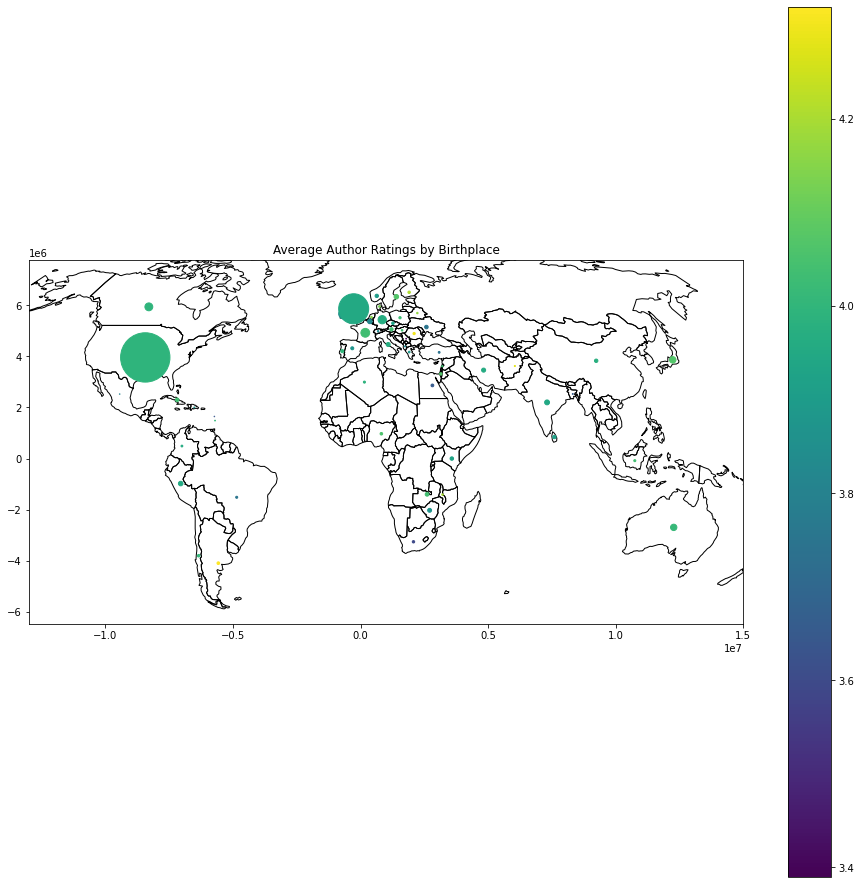

In [83]:
ax = world.to_crs("ESRI:53030").plot(facecolor="none", figsize=(16, 16))
gdf_author.to_crs("ESRI:53030").plot(ax=ax, column="author_average_rating", legend=True,
                                     markersize=0.3 * author_country["num_authors"])
ax.set_title("Average Author Ratings by Birthplace")
ax.set_xlim(-1.3e7, 1.5e7)
ax.set_ylim(-6.5e6, 7.8e6)
plt.show()

## Popularity of Genres -- all time and across the centruy
1. Popularity of genres overall
2. Popularity of genres over time

In [93]:
df_books['genre'] = df_books['genre'].apply(lambda x: [genre.strip().strip("'") for genre in x[2:-2].split(',')])

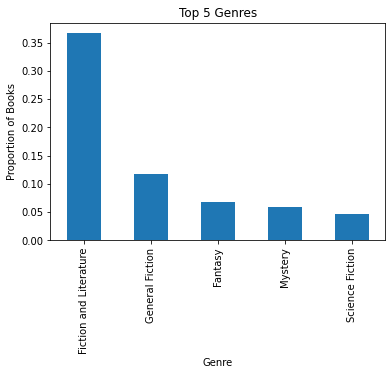

In [94]:
import matplotlib.pyplot as plt

# generate the series
genre_counts = df_books['genre'].explode().value_counts(normalize=True).head(5)

# create a bar plot of the normalized data
genre_counts.plot(kind='bar')
plt.title('Top 5 Genres')
plt.xlabel('Genre')
plt.ylabel('Proportion of Books')
plt.show()

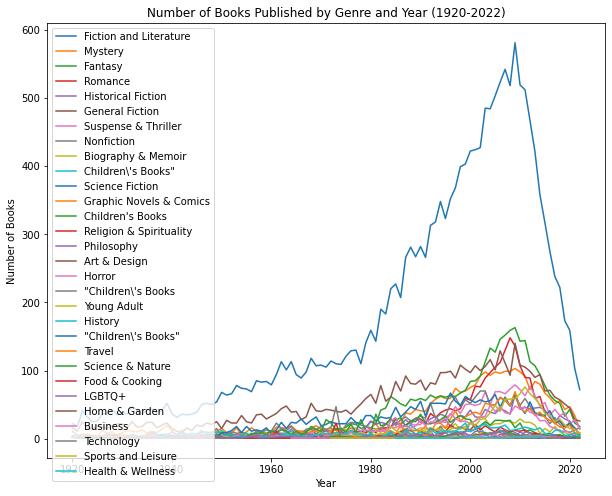

In [96]:
import matplotlib.pyplot as plt

exploded_genres = df_books['genre'].explode()

# get a list of unique genres
unique_genres = exploded_genres.unique()

plt.figure(figsize=(10, 8))
# get the subset of the DataFrame for the current genre and the years 1920-2022
for genre in unique_genres:
    genre_df = df_books[df_books['genre'].apply(lambda x: genre in x)]
    genre_df = genre_df[genre_df['publication_year'].astype(int).between(1920, 2022)]
    genre_grouped = genre_df.groupby('publication_year').size()
    plt.plot(genre_grouped.index, genre_grouped.values, label=genre)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.title('Number of Books Published by Genre and Year (1920-2022)')
plt.show()

In [98]:
#most popular books
df_books.nlargest(10, ['avg_rating'])

,title,author,book_index,book_url,avg_rating,genre,description,publication_year,first_sentence,number_of_reviews,image_url
2595,Turn Again Home,Carol Birch,2595,https://www.librarything.com//work/1135738,5.0,"[Fiction and Literature, General Fiction, Hist...","Gorton, Manchester. 1930. Greyhound racing at ...",2003,"In spring, in Rome, the petals of the cherry t...",1,https://images-na.ssl-images-amazon.com/images...
4752,Famous American Plays of the 1960s,Harold Clurman,4752,https://www.librarything.com//work/610171,5.0,[Fiction and Literature],"Some of the plays included are Hogan's Goat, T...",1972,NaN,1,https://pics.cdn.librarything.com/picsizes/72/...
7935,Legends of King Arthur: Idylls of the King (Te...,Alfred Tennyson,7935,https://www.librarything.com//work/23596700,5.0,[Fiction and Literature],Tennyson enjoyed great success with his poem '...,2009,NaN,1,https://images-na.ssl-images-amazon.com/images...
8569,Selected Poetry of William Wordsworth (Modern ...,William Wordsworth,8569,https://www.librarything.com//work/7896098,5.0,[Fiction and Literature],"Collects poems by William Wordsworth, includin...",1950,NaN,1,https://images-na.ssl-images-amazon.com/images...
9941,Who's Got Game? The Lion or the Mouse?,Toni Morrison,9941,https://www.librarything.com//work/3523194,5.0,"[Fiction and Literature, Graphic Novels & Comics]","Generation after generation, classic fables, f...",2003,NaN,2,https://pics.cdn.librarything.com/picsizes/dc/...
11662,The FBI Profiler Series 6-Book Bundle: The Per...,Lisa Gardner,11662,https://www.librarything.com//work/14216681,5.0,"[Fiction and Literature, Suspense & Thriller]","Throughout this electrifying series from ""one ...",2013,NaN,0,https://pics.cdn.librarything.com/picsizes/fb/...
16032,"Laura Ingalls Wilder: The Little House Books, ...",Laura Ingalls Wilder,16032,https://www.librarything.com//work/12911579,5.0,"[Fiction and Literature, General Fiction]","Originally published from 1932 to 1943, Laura ...",2012,NaN,1,https://images-na.ssl-images-amazon.com/images...
18718,A House is Built at Pooh Corner for Eeyore,A. A. Milne,18718,https://www.librarything.com//work/156325,5.0,[Children's Books],"One cold, snowy day Pooh and Piglet go to visi...",1928,NaN,1,https://pics.cdn.librarything.com/picsizes/e6/...
18954,The Daughter of the Moon,Gregory Maguire,18954,https://www.librarything.com//work/800403,5.0,[Fiction and Literature],Twelve-year-old Erikka's opportunities to step...,1980,NaN,0,https://pics.cdn.librarything.com/picsizes/7e/...
19851,Let Sleeping Dragons Lie,Garth Nix,19851,https://www.librarything.com//work/22335562,5.0,[Fiction and Literature],Odo and Eleanor are excited to be knights. Onl...,2018,NaN,0,https://images-na.ssl-images-amazon.com/images...


<Axes: xlabel='author'>

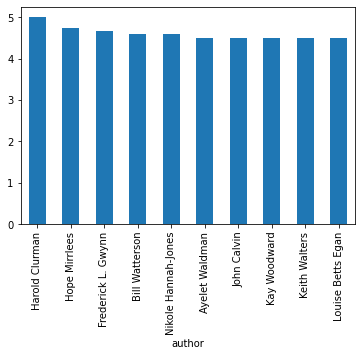

In [99]:
# most popular authors
df_books.groupby('author')['avg_rating'].mean().nlargest(10).plot.bar()

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='number_of_reviews', ylabel='avg_rating'>

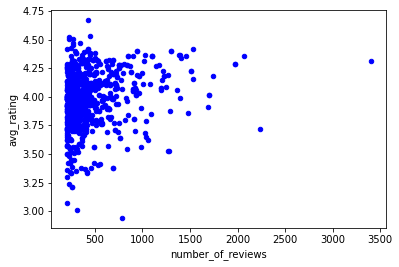

In [100]:
#scatterplot of number of reviews and rating
df_books[df_books['number_of_reviews']>200].plot.scatter(x='number_of_reviews',
                       y='avg_rating',
                       c='blue')

## Question 3: Most Popular Books

In [101]:
df_books = df_books[df_books['number_of_reviews'] != 'None']
df_books.loc[:,'number_of_reviews'] = df_books['number_of_reviews'].astype(int)

df_filter = df_books[df_books['number_of_reviews'] > 100]
df_filter.nlargest(10, ['avg_rating'])

,title,author,book_index,book_url,avg_rating,genre,description,publication_year,first_sentence,number_of_reviews,image_url
23301,"Thank You, Mr. Falker",Patricia Polacco,23301,https://www.librarything.com//work/322175,4.67,[Children's Books],"At first, Trisha loves school, but her difficu...",1998,The grandpa held the jar of honey so that all ...,425,https://images-na.ssl-images-amazon.com/images...
166,Harry Potter (Books 1-7),J. K. Rowling,166,https://www.librarything.com//work/3107552,4.64,"[Fiction and Literature, Fantasy]",Collects the complete series that relates the ...,2007,NaN,168,https://images-na.ssl-images-amazon.com/images...
23307,The Junkyard Wonders,Patricia Polacco,23307,https://www.librarything.com//work/9872654,4.64,[Children's Books],Inspired by a teacher who believes each of the...,2010,My heart sang as I walked to school with all o...,140,https://images-na.ssl-images-amazon.com/images...
16530,Words of Radiance,Brandon Sanderson,16530,https://www.librarything.com//work/13306364,4.60,"[Fiction and Literature, Fantasy]","The war with the Parshendi moves into a new, d...",2014,"Jasnah Kholin pretended to enjoy the party, gi...",127,https://images-na.ssl-images-amazon.com/images...
31,The Complete Works of William Shakespeare,William Shakespeare,31,https://www.librarything.com//work/2480465,4.59,[Fiction and Literature],This single-volume edition of the complete wor...,1589,William Shakespeare's date of birth is not pre...,165,https://images-na.ssl-images-amazon.com/images...
837,The Lord of the Rings,J. R. R. Tolkien,837,https://www.librarything.com//work/1386651,4.53,"[Fantasy, Fiction and Literature, General Fict...","Celebrating the birth of J.R.R. Tolkien, this ...",1968,When Mr. Bilbo Baggins of Bag End announced th...,445,https://images-na.ssl-images-amazon.com/images...
7812,The Complete Maus,Art Spiegelman,7812,https://www.librarything.com//work/6046618,4.52,[Graphic Novels & Comics],Maus is a haunting tale within a tale. Vladek'...,1986,Last one to the schoolyard is a rotten egg.,225,https://images-na.ssl-images-amazon.com/images...
17235,We Are in a Book!,Mo Willems,17235,https://www.librarything.com//work/10049034,4.52,[Children's Books],Gerald and Piggie discover the joy of being re...,2010,NaN,128,https://images-na.ssl-images-amazon.com/images...
7444,A Court of Mist and Fury,Sarah J. Maas,7444,https://www.librarything.com//work/16507274,4.51,"[Fantasy, Fiction and Literature, Young Adult]",Though Feyre now has the powers of the High Fa...,2016,Maybe I'd always been broken and dark inside.,226,https://images-na.ssl-images-amazon.com/images...
12544,Each Kindness,Jacqueline Woodson,12544,https://www.librarything.com//work/13021580,4.51,[Children's Books],"When Ms. Albert teaches a lesson on kindness, ...",2012,"That winter, snow fell on everything, turning ...",273,https://images-na.ssl-images-amazon.com/images...


After filtering books to only include ones with more than 100 reviews, we found that the top 10 books with the highest rating include Harry Potter, Lord of the Rings, and some children's books.

<Axes: xlabel='author'>

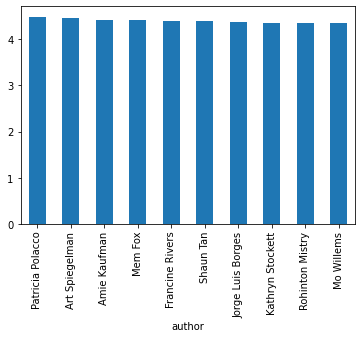

In [102]:
df_books = df_books[df_books['number_of_reviews'] != 'None']
df_books.loc[:,'number_of_reviews'] = df_books['number_of_reviews'].astype(int)

df_filter = df_books[df_books['number_of_reviews'] > 100]
df_filter.groupby('author')['avg_rating'].mean().nlargest(10).plot.bar()

The authors with the highest average rating of books is Harold Churman.

# Exploring Word Trends

The first sentence of a book is an author's chance to hook the reader in -- as such, authors are highly incentivized to make the first sentence something that will pique the reader's interest. We wondered if it may reflect cultural zeitgeists -- readers in different eras sought different types of words or emotions in the books they'd read. 

We wanted to see trends in how these critical first-sentences evolved over time.

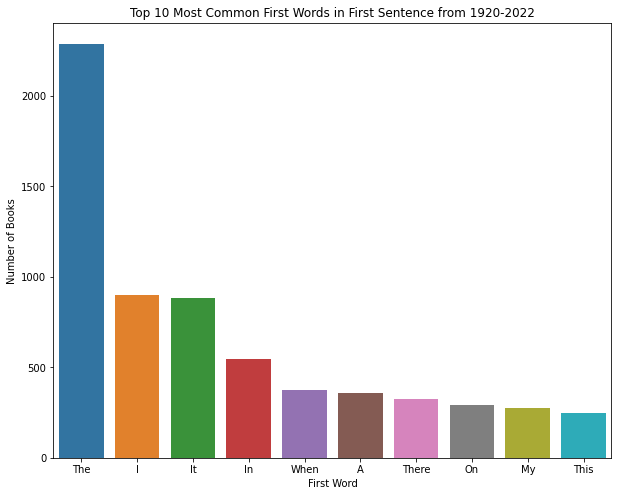

In [104]:
import seaborn as sns

#make a new column "first_word" that is the first word of "first_sentence"
df_books['first_word'] = df_books['first_sentence'].str.split().str[0]
#calculate the top 10 most common first words in the first sentence
df_books['first_word'].value_counts().nlargest(10)

plt.figure(figsize=(10, 8))
sns.countplot(x='first_word', data=df_books, order=df_books['first_word'].value_counts().nlargest(10).index)
plt.xlabel('First Word')
plt.ylabel('Number of Books')
plt.title('Top 10 Most Common First Words in First Sentence from 1920-2022')
plt.show()

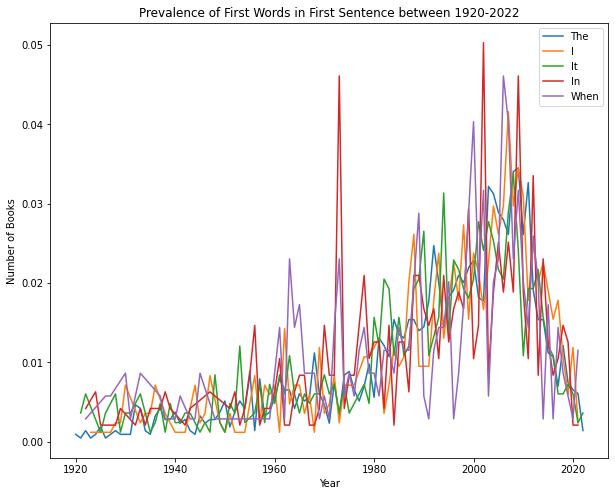

In [105]:
plt.figure(figsize=(10, 8))
for i in range(5):
    word = df_books['first_word'].value_counts().nlargest(5).index[i]
    word_df = df_books[df_books['first_word'] == word]
    word_df = word_df[word_df['publication_year'].between(1920, 2022)]
    word_grouped = word_df.groupby('publication_year').size()
    plt.plot(word_grouped.index, word_grouped.values/word_grouped.values.sum(), label=word)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.title('Prevalence of First Words in First Sentence between 1920-2022')
plt.show()


One word doesn't really show much. What about the first two words?


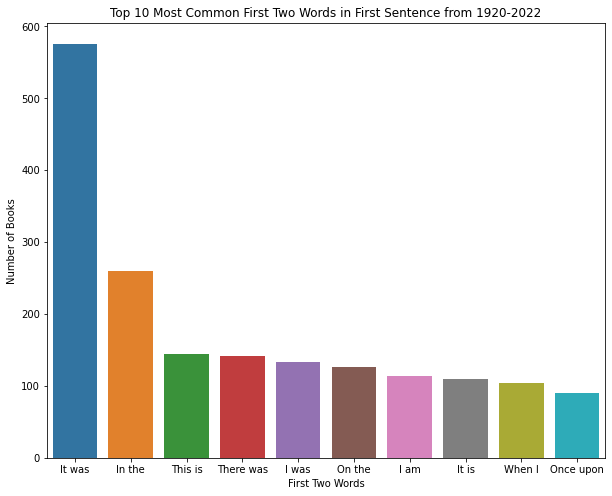

In [106]:
#make a new column "first_word" that is the first two word of "first_sentence"
df_books['first_twowords'] = df_books['first_sentence'].str.split().str[:2].str.join(' ')
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.countplot(x='first_twowords', data=df_books, order=df_books['first_twowords'].value_counts().nlargest(10).index)
plt.xlabel('First Two Words')
plt.ylabel('Number of Books')
plt.title('Top 10 Most Common First Two Words in First Sentence from 1920-2022')
plt.show()

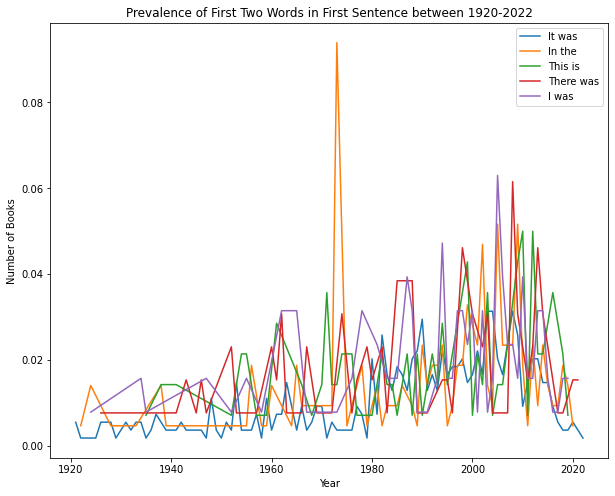

In [107]:
plt.figure(figsize=(10, 8))
for i in range(5):
    word = df_books['first_twowords'].value_counts().nlargest(5).index[i]
    word_df = df_books[df_books['first_twowords'] == word]
    word_df = word_df[word_df['publication_year'].between(1920, 2022)]
    word_grouped = word_df.groupby('publication_year').size()
    plt.plot(word_grouped.index, word_grouped.values/word_grouped.values.sum(), label=word)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.title('Prevalence of First Two Words in First Sentence between 1920-2022')
plt.show()